## Setup model

### Initialize electrode locations

In [1]:
import numpy as np
import pandas as pd
import h5py

# elec_pos = np.column_stack((np.zeros(96),np.linspace(-1900,1900,96),np.zeros(96)))

# # save electrode position to file
# elec_file = 'sim_details/linear_electrode.csv'
# df = {'channel':np.arange(elec_pos.shape[0])}
# df.update({x+'_pos':elec_pos[:,i] for i,x in enumerate(list('xyz'))})
# df = pd.DataFrame(df)
# df.to_csv(elec_file,sep=' ',index=False)

with h5py.File('Electrode2D.h5', "r") as f:
    elec_file = 'sim_details/linear_electrode.csv'  # It isn't linear but in order to not change configs I kept the name
    elec_pos = np.hstack((f['coord'][:], np.zeros((384,1))))
    df = {'channel':np.arange(elec_pos.shape[0])}
    df.update({x+'_pos':elec_pos[:,i] for i,x in enumerate(list('xyz'))})
    df = pd.DataFrame(df)
    df.to_csv(elec_file,sep=' ',index=False)

### Select model

In [2]:
# model_name = 'neuronal_model_496930324'
# syn_weight = 0.01
# model_name = 'neuronal_model_497229089'
# syn_weight = 0.03
model_name = 'neuronal_model_491766131'
syn_weight = 0.02

dynamics_params = model_name + '.json'
morphology = model_name+'_rotate.swc'

#### Copy model files

In [3]:
import os, shutil

# shutil.copy(model_name + '/fit_parameters.json','sim_details/components/biophysical_neuron_models/' + dynamics_params)

### Select translation distance and rotation angles, and convert to euler angles in bmtk

In [4]:
import numpy as np
from scipy.spatial.transform import Rotation as R

x = 0
y = 350
z = 80
theta = 0.
h = 0.7071
phi = 0.

Rot = R.from_euler('yxy',[theta,np.arccos(h),phi])
rot_zyx = Rot.as_euler('zyx')

In [5]:
# # block basal dendrite
# model_name += '_nobasal'
# dynamics_params = model_name + '.json'

## Build bmtk network

In [6]:
from bmtk.builder.networks import NetworkBuilder

net = NetworkBuilder('Cell')
net.add_nodes(cell_name = 'Cell',
              positions = np.array([[x,y,z]]),
              rotation_angle_xaxis = rot_zyx[2], # rotation cell
              rotation_angle_yaxis = rot_zyx[1],
              rotation_angle_zaxis = rot_zyx[0],
#               orientation=quaternion, # this option seems not implemented in bmtk
              potental = 'exc',
              model_type = 'biophysical',
              model_template = 'ctdb:Biophys1.hoc',
              model_processing = 'aibs_allactive',
              dynamics_params = dynamics_params, #from allen database
              morphology = morphology) # rotated swc file

In [7]:
net.build()
net.save_nodes(output_dir='network')

In [8]:
source = NetworkBuilder('Source')
source.add_nodes(N=1,pop_name='Source',potential='exc',model_type='virtual')

In [9]:
source.add_edges(source={'pop_name':'Source'},target=net.nodes(),
                   connection_rule=1,
                   syn_weight=syn_weight,
                   delay=0.0,
                   weight_function=None,
                   target_sections=['soma'],
                   distance_range=[0.0,1000.0],
                   dynamics_params='AMPA_ExcToExc.json',
                   model_template='exp2syn')

In [10]:
source.build()
source.save_nodes(output_dir='network')
source.save_edges(output_dir='network')

#### Synaptic input spike

In [11]:
import pandas as pd

syn_time = 10.0
spike = pd.DataFrame(data={'node_ids':[0],'timestamps':[syn_time],'population':['Source']})
spike.to_csv('sim_details/synaptic_input.csv',sep=' ',index=False)

## Build

#### Create config for the first time

In [12]:
# from bmtk.utils.sim_setup import build_env_bionet

# build_env_bionet(base_dir='sim_details',
#                  network_dir='network',
#                  tstop=30.0, dt=0.025,
#                  v_init=-91.63188171386719, # use e_pas in dynamics_params file
#                  report_vars=['v','ecp'],
#                  spikes_inputs=[('Source','sim_details/synaptic_input.csv')],
#                  config_file = 'config.json',
#                  include_examples=True,    # Copies components files
#                  compile_mechanisms=True   # Will try to compile NEURON mechanisms
#                 )

#### Load from source config file

In [13]:
import json

source_config = 'simulation_config.json'
target_config = 'sim_details/simulation_config.json'

with open(source_config) as f:
    config = json.load(f)

#### Change settings

In [14]:
Record_im = True # record transmembrane current

config['run']['tstop'] = 30.0
# config['run']['dt'] = 0.025
# config['conditions']['v_init'] = -90.0

if Record_im:
    config['reports']['imem_report'] = { 'variable_name': 'i_membrane_',
                                         'cells': 'all',
                                         'module': 'membrane_report',
                                         'file_name': 'imem.h5',
                                         'sections': 'all' }
else:
    del config['reports']['ecp_report']

#### Write to targe config file

In [15]:
with open(target_config, 'w') as f:
    json.dump(config, f, indent=2)

## Run bmtk

In [16]:
from bmtk.simulator import bionet

conf = bionet.Config.from_json('sim_details/config.json')
conf.build_env()
net = bionet.BioNetwork.from_config(conf)
sim = bionet.BioSimulator.from_config(conf, network=net)

2022-08-20 18:13:35,093 [INFO] Created log file
2022-08-20 18:13:35,294 [INFO] Building cells.
2022-08-20 18:13:35,736 [INFO] Building recurrent connections
2022-08-20 18:13:35,741 [INFO] Building virtual cell stimulations for Source_spikes


### Observe cell

In [17]:
cell_id = 0

#### Record axial current

In [18]:
from utils.currents.somaaxialcurrent import Soma_Axial_Current

axial_current = Soma_Axial_Current(sim.net.get_cell_gid(cell_id).get_section(0),record_t=True)
sim.run()

2022-08-20 18:13:35,950 [INFO] Running simulation for 30.000 ms with the time step 0.025 ms
2022-08-20 18:13:35,951 [INFO] Starting timestep: 0 at t_sim: 0.000 ms
2022-08-20 18:13:35,952 [INFO] Block save every 1200 steps
2022-08-20 18:13:39,504 [INFO]     step:1200 t_sim:30.00 ms
2022-08-20 18:13:39,617 [INFO] Simulation completed in 3.668 seconds 


#### Check morphology
Function to plot morphology

In [19]:
from mpl_toolkits import mplot3d
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from matplotlib import cm
import matplotlib.pyplot as plt
%matplotlib notebook

def plot_morphology(network,gid=0,rotated=True,figsize=(8,6),ax=None):
    cell = network.get_cell_gid(gid)
    morph = cell.morphology
    if rotated:
        coords = cell.get_seg_coords()
    else:
        coords = morph.seg_coords
    stype = morph.seg_prop['type'].astype(int)-1
    st = list(morph.sec_type_swc.keys())[::2]
    ilab = [list(stype).index(i) for i in range(len(st))]
    clr = ['g','r','b','c']
    if ax is None:
        print(cell.morphology_file)
        fig = plt.figure(figsize=figsize)
        ax = plt.axes(projection='3d')
    else:
        fig = ax.figure
        fig.set_size_inches(figsize)
    for i in range(stype.size):
        label = st[ilab.index(i)] if i in ilab else None
        if stype[i]==0:
            ax.scatter(*coords['p05'][:,i].tolist(),c=clr[0],s=30,label=label)
        else:
            ax.plot3D(*[[coords['p0'][j,i],coords['p1'][j,i]] for j in range(3)],
                      color=clr[stype[i]],label=label)
    ax.legend(loc=1)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    return fig, ax

In [20]:
# %matplotlib notebook

# _ = plot_morphology(net,cell_id,rotated=True)

Check diameters

## Check Results

In [21]:
import h5py
import numpy as np
import pandas as pd
import os

outpath = 'sim_details/output/'
time_window_save = [syn_time - 2., syn_time + 12.]

### Check membrane voltage

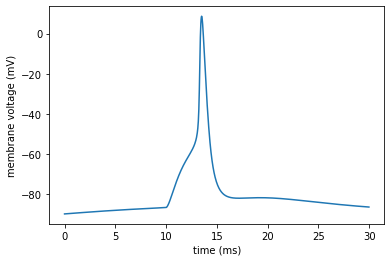

In [22]:
filename = 'v_report.h5'
v_file = outpath + filename
with h5py.File(v_file,'r') as v_f:
    idx = v_f['report/Cell/mapping/node_ids'][()].tolist().index(cell_id)
    idx = slice(*v_f['report/Cell/mapping/index_pointer'][()][[idx, idx+1]])
    V = v_f['report/Cell/data'][()][:,idx]
    t = np.arange(*v_f['report/Cell/mapping/time']) # array of time

import matplotlib.pyplot as plt
%matplotlib inline

plt.figure()
plt.plot(t,V)
plt.xlabel('time (ms)')
plt.ylabel('membrane voltage (mV)')
plt.show()

### Check axial currents

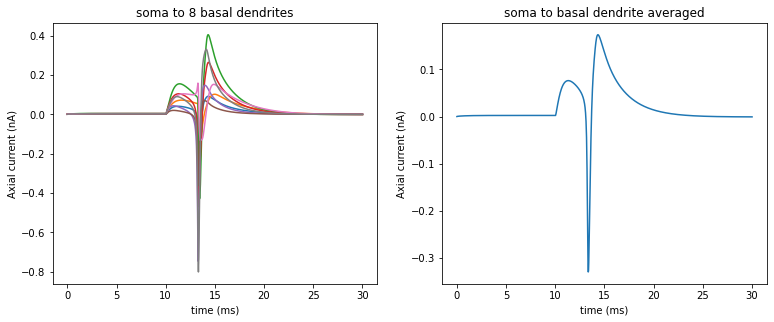

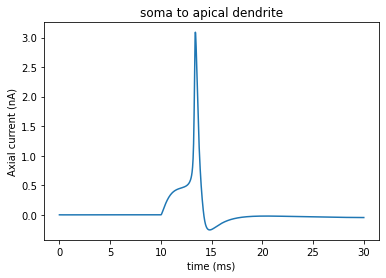

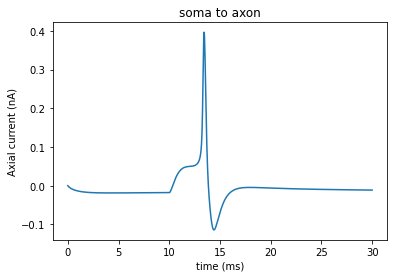

In [23]:
t = axial_current.t()
ac = axial_current.get_current()

ac_dend = ac['dend'].T
plt.figure(figsize=(12.8, 4.8))
plt.subplot(121)
plt.plot(t,ac_dend)
plt.xlabel('time (ms)')
plt.ylabel('Axial current (nA)')
plt.title('soma to {} basal dendrites'.format(ac_dend.shape[1]))
plt.subplot(122)
plt.plot(t,np.mean(ac_dend,axis=1))
plt.xlabel('time (ms)')
plt.ylabel('Axial current (nA)')
plt.title('soma to basal dendrite averaged')
plt.show()

ac_apic = ac['apic'].T
plt.figure()
plt.plot(t,ac_apic)
plt.xlabel('time (ms)')
plt.ylabel('Axial current (nA)')
plt.title('soma to apical dendrite')
plt.show()

ac_axon = ac['axon'].T
plt.figure()
plt.plot(t,ac_axon)
plt.xlabel('time (ms)')
plt.ylabel('Axial current (nA)')
plt.title('soma to axon')
plt.show()

### Check LFP

In [24]:
from scipy import signal

if Record_im:
    filename = 'ecp.h5'
    ecp_file = outpath + filename
    with h5py.File(ecp_file,'r') as ecp_f:
        lfp = ecp_f['ecp/data'][()]
        t = np.arange(*ecp_f['ecp/time']) # array of time
        dt = ecp_f['ecp/time'][2]

    filt_b,filt_a = signal.butter(2,100,'hp',fs=1000/dt)
    lfp_filt = signal.lfilter(filt_b,filt_a,lfp,axis=0)
    t_idx = (t>=time_window_save[0]) & (t<=time_window_save[1])

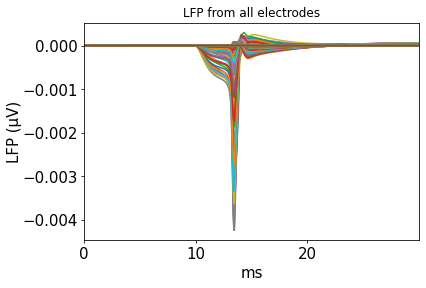

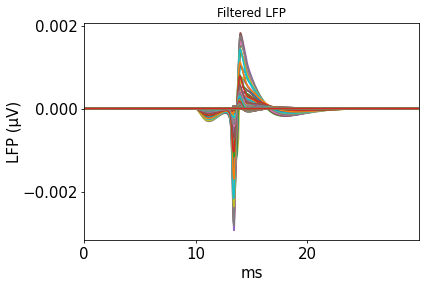

In [25]:
from utils.plotting.plot_results import *

if Record_im:
    idx = (t>=0) & (t<=30)

    fig,ax = plot_lfp_traces(t[idx],lfp[idx,:],
                             fontsize=15,labelpad=0,ticksize=15,tick_length=3,nbins=5)
    ax.set_title('LFP from all electrodes')

    fig,ax = plot_lfp_traces(t[idx],lfp_filt[idx,:],
                             fontsize=15,labelpad=0,ticksize=15,tick_length=3,nbins=5)
    ax.set_title('Filtered LFP')

Using column at x = -8 um


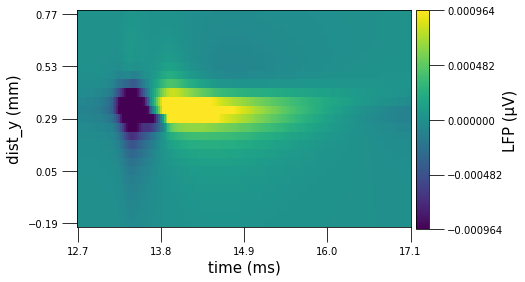

In [26]:
if Record_im:
    window = 4.4
    tstart = 12.7
    # tstart = 10.5 # no basal
    idx = (t>=tstart) & (t<=tstart+window)

    vlim = 'auto'
    # vlim = [-0.0005,0.0005]
    ylim = [-200,800]

    x_dist = np.unique(elec_pos[:,0])
    ix = 1
    e_idx = (elec_pos[:,0]==x_dist[ix]) & (elec_pos[:,1]>=ylim[0]) & (elec_pos[:,1]<=ylim[1])
    print('Using column at x = %g um' % (x_dist[ix]))

    fig,ax = plot_lfp_heatmap(t[idx],elec_pos[e_idx, 1],
                              lfp_filt[idx][:, e_idx],vlim=vlim,
                              fontsize=15,labelpad=0,ticksize=10,nbins=5)

#### Save LFP to h5 file

In [27]:
# if Record_im:
#     lfp_file_name = 'lfp_result/' + model_name + '_h' + str(h) + '.h5'
#     with h5py.File(lfp_file_name, 'w') as hf:
#         hf.attrs['dt'] = dt
#         hf.create_dataset('data',data=lfp_filt[t_idx,:])
#         for dend, AC in ac.items():
#             hf.create_dataset('axial_current/'+dend,data=AC[:,t_idx])

## Check morphology

#### Get segment coordinates for given cell and calculate electrotonic distance

In [28]:
cell = sim.net.get_cell_gid(cell_id)

morph = cell.morphology
seg_coords = {}
seg_coords['dl'] = (morph.seg_coords['p1']-morph.seg_coords['p0']).T
seg_coords['pc'] = morph.seg_coords['p05'].T
seg_coords['r'] = np.fmax(morph.seg_coords['d0'], morph.seg_coords['d1'])/2

In [29]:
from utils.metrics.measure_segment_distance import measure_segment_distance

soma = cell.hobj.soma[0]
section_list = cell._secs_by_id
sec_type = [morph.sec_type_swc[sec.name().split('.')[1][:4]] for sec in section_list]
freq = 0 # Hz

seg_prop, Rin, Rin_pha = measure_segment_distance(soma, section_list, sec_type, freq, extracellular_mechanism=Record_im)
print(Rin, Rin_pha) # Megohms, rad

65.37087571750126 0.0


In [30]:
morph_file_name = 'lfp_result/' + model_name + '_SegProp.h5'
with h5py.File(morph_file_name, 'w') as hf:
    grp = hf.create_group('seg_prop')
    for key, value in seg_prop.items():
        grp.create_dataset(key, data=value)

#### Stretch the cell to make it circularly symmetric

In [31]:
from sklearn.decomposition import PCA
from copy import deepcopy

Strech = False

if Strech:
    pca = PCA()
    basal_idx = (seg_prop['swc_type']==3) | (seg_prop['swc_type']==4)
    pca.fit(seg_coords['pc'][basal_idx][:,[0,2]])
    z_scale = (pca.explained_variance_[0] / pca.explained_variance_[1]) ** 0.5
    seg_coords_stretch = deepcopy(seg_coords)
    seg_coords_stretch['dl'][:, 2] *= z_scale
    seg_coords_stretch['pc'][:, 2] *= z_scale

### Check transmembrane currents

#### Collect transmembrane currents and save to h5 file

In [32]:
if Record_im:
    filename = 'imem.h5'
    im_file = outpath + filename

    with h5py.File(im_file,'r') as im_f:
        dt = im_f['report/Cell/mapping/time'][2]
        t = np.arange(*im_f['report/Cell/mapping/time'])
        t_idx = (t>=time_window_save[0]) & (t<=time_window_save[1])
        idx = im_f['report/Cell/mapping/node_ids'][()].tolist().index(cell_id)
        idx = slice(*im_f['report/Cell/mapping/index_pointer'][()][[idx, idx+1]])
        im = im_f['report/Cell/data'][()][t_idx, idx].T

    im_file_name = 'lfp_result/' + model_name + '_Im.h5'
    with h5py.File(im_file_name, 'w') as hf:
        hf.attrs['dt'] = dt
        hf.create_dataset('data', data=im)
        grp = hf.create_group('seg_coords')
        for key, value in seg_coords.items():
            grp.create_dataset(key, data=value)

    if Strech:
        im_strch_file_name = 'lfp_result/' + model_name + '_Im_strch.h5'
        with h5py.File(im_strch_file_name, 'w') as hf:
            hf.attrs['dt'] = dt
            hf.create_dataset('data', data=im)
            grp = hf.create_group('seg_coords')
            for key, value in seg_coords_stretch.items():
                grp.create_dataset(key, data=value)